# LAMMPS-RNEMD計算結果から粘度・熱伝導率を解析するスクリプト

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from scipy import stats

### モーメント交換量を解析する関数

In [2]:
def AnalyzeExchangedMomenta (prefix, name):
    # データ読込みと平均化
    time = []
    mom  = []
    area = []
    lz   = []
    dens = []
    with open (prefix + name, "r") as fp:    
        for i in range (2): next (fp)
        list = fp.readlines ()
        p = 0
        for line in list:
            line = line.rstrip ().split (" ")
            time.append (float (line[1]))
            mom.append (float (line[2]))
            area.append (float (line[3]))
            lz.append (float (line[4]))
            dens.append (float (line[5]))
            p += 1
    ave_lz = np.sum (lz) / float (p)
    ave_dens = np.sum (dens) / float (p)
    x = np.zeros (p)
    for i in range (p): x[i] = 2.0 * time[i] * area[i]
    
    # 線形近似
    slope, intercept, r_value, p_value, std_err = stats.linregress (x, mom) 
    r = r_value * r_value
    flux = (slope / 6.0221367e23 * 1.0e15 * 1.0e-10 * 1.0e-3) * (1.0e15 * 1.0e10 * 1.0e10)  
    
    # グラフ化
    fig = plt.figure (figsize = (8, 8)) 
    plt.plot (x, mom, label = "Row data", marker = ".", markersize = 5, linestyle = "none", color = "gray")
    plt.plot (x, x * slope + intercept, label = "Fitted (R^2 = {:.3f})".format (r), linestyle = "solid", color = "blue")
    plt.xlabel ("2tXY (fs.A^2)")
    plt.ylabel ("Exchanged momenta (amu.A/fs)")
    plt.legend ()
    fig.savefig (prefix + "momenta.png") 
    
    return ave_lz, ave_dens, flux

### 速度プロファイルを解析する関数

In [6]:
def AnalyzeVelocityDistribution (mesh, lz, lin, prefix, name):
    # データ読込みと平均化
    pos = np.zeros (mesh)
    vel = np.zeros (mesh)
    with open (prefix + name, "r") as fp:
        for i in range (3): next (fp)
        list = fp.readlines ()
        p = 0
        n = 0
        for line in list:
            if n > mesh:
                n = 0
                p += 1
            if n == 0:
                n += 1
                continue
            line = line.rstrip ().split (" ")
            if p == 0: pos[n - 1] = float (line[3])
            vel[n - 1] += float (line[5])
            n += 1
    pos *= lz
    vel /= float (p)
    
    # 線形近似（下側）
    x1 = pos[1:int (mesh / 2)]
    v1 = vel[1:int (mesh / 2)]
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress (x1, v1)    
    r1 = r_value1 * r_value1
    
    # 線形近似（上側）
    x2 = pos[int (mesh / 2) + 1:mesh]
    v2 = vel[int (mesh / 2) + 1:mesh]    
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress (x2, v2)    
    r2 = r_value2 * r_value2    
    
    # 速度勾配の平均値 [1/s]
    if lin == True:
        dvdz = 0.5 * (np.abs (slope1) + np.abs (slope2)) * 1.0e15
    else:
        dvdz = (vel[int (mesh / 2)] - vel[0]) / (pos[int (mesh / 2)] - pos[0]) * 1.0e15
        x3 = [pos[0], pos[int (mesh / 2)]]
        v3 = [vel[0], vel[int (mesh / 2)]]

    # グラフ化
    fig = plt.figure (figsize = (8, 8)) 
    plt.plot (vel, pos, label = "Row data", marker = ".", markersize = 9, linestyle = "solid", color = "gray")
    if lin == True:
        plt.plot (v1, x1, marker = ".", markersize = 10, linestyle = "none", color = "blue")
        plt.plot (x1 * slope1 + intercept1, x1, label = "Fitted (R^2 = {:.3f})".format (r1), linestyle = "solid", color = "blue")
        plt.plot (v2, x2, marker = ".", markersize = 10, linestyle = "none", color = "coral")
        plt.plot (x2 * slope2 + intercept2, x2, label = "Fitted (R^2 = {:.3f})".format (r2), linestyle = "solid", color = "coral")
    else:
        plt.plot (v3, x3, marker = ".", markersize = 10, linestyle = "none", color = "blue")
        plt.plot (v3, x3, label = "dVx/dZ", linestyle = "solid", color = "blue")
    plt.xlabel ("X-velocity (A/fs)")
    plt.ylabel ("Z-position (A)")
    plt.legend ()
    fig.savefig (prefix + "profile.png")
    
    return dvdz

### 運動エネルギー交換量を解析する関数

In [7]:
def AnalyzeExchangedEnergy (prefix, name):
    # データ読込みと平均化
    time = []
    ene  = []
    area = []
    lz   = []
    dens = []
    with open (prefix + name, "r") as fp:    
        for i in range (2): next (fp)
        list = fp.readlines ()
        p = 0
        for line in list:
            line = line.rstrip ().split (" ")
            time.append (float (line[1]))
            ene.append (float (line[2]))
            area.append (float (line[3]))
            lz.append (float (line[4]))
            dens.append (float (line[5]))
            p += 1
    ave_lz = np.sum (lz) / float (p)
    ave_dens = np.sum (dens) / float (p)
    x = np.zeros (p)
    for i in range (p): x[i] = 2.0 * time[i] * area[i]
    
    # 線形近似
    slope, intercept, r_value, p_value, std_err = stats.linregress (x, ene) 
    r = r_value * r_value
    flux = (slope / 6.0221367e23 * 4.184 * 1.0e3) * (1.0e15 * 1.0e10 * 1.0e10)  
  
    # グラフ化
    fig = plt.figure (figsize = (8, 8)) 
    plt.plot (x, ene, label = "Row data", marker = ".", markersize = 5, linestyle = "none", color = "gray")
    plt.plot (x, x * slope + intercept, label = "Fitted (R^2 = {:.3f})".format (r), linestyle = "solid", color = "blue")
    plt.xlabel ("2tXY (fs.A^2)")
    plt.ylabel ("Exchanged kinetic energy (kcal/mol)")
    plt.legend ()
    fig.savefig (prefix + "energy.png") 
    
    return ave_lz, ave_dens, flux

### 温度プロファイルを解析する関数

In [8]:
def AnalyzeTemperatureDistribution (mesh, lz, lin, prefix, name):
    # データ読込みと平均化
    pos = np.zeros (mesh)
    tmp = np.zeros (mesh)
    gas = 8.314 / 4.184 * 1.0e-3 # gas constant in [kcal/(mol.K)]
    with open (prefix + name, "r") as fp:
        for i in range (3): next (fp)
        list = fp.readlines ()
        p = 0
        n = 0
        for line in list:
            if n > mesh:
                n = 0
                p += 1
            if n == 0:
                n += 1
                continue
            line = line.rstrip ().split (" ")
            if p == 0: pos[n - 1] = float (line[3])
            tmp[n - 1] += float (line[5]) / gas
            n += 1
    pos *= lz
    tmp /= float (p)
    
    # 線形近似（下側）
    x1 = pos[1:int (mesh / 2)]
    t1 = tmp[1:int (mesh / 2)]
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress (x1, t1)    
    r1 = r_value1 * r_value1
    
    # 線形近似（上側）
    x2 = pos[int (mesh / 2) + 1:mesh]
    t2 = tmp[int (mesh / 2) + 1:mesh]    
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress (x2, t2)    
    r2 = r_value2 * r_value2    
    
    # 温度勾配の平均値 [K/m]
    if lin == True:
        dtdz = 0.5 * (np.abs (slope1) + np.abs (slope2)) * 1.0e10
    else:
        dtdz = (tmp[int (mesh / 2)] - tmp[0]) / (pos[int (mesh / 2)] - pos[0]) * 1.0e10
        x3 = [pos[0], pos[int (mesh / 2)]]
        t3 = [tmp[0], tmp[int (mesh / 2)]]
    
    # グラフ化
    fig = plt.figure (figsize = (8, 8)) 
    plt.plot (tmp, pos, label = "Row data", marker = ".", markersize = 9, linestyle = "solid", color = "gray")
    if lin == True:
        plt.plot (t1, x1, marker = ".", markersize = 10, linestyle = "none", color = "blue")
        plt.plot (x1 * slope1 + intercept1, x1, label = "Fitted (R^2 = {:.3f})".format (r1), linestyle = "solid", color = "blue")
        plt.plot (t2, x2, marker = ".", markersize = 10, linestyle = "none", color = "coral")
        plt.plot (x2 * slope2 + intercept2, x2, label = "Fitted (R^2 = {:.3f})".format (r2), linestyle = "solid", color = "coral")
    else:
        plt.plot (t3, x3, marker = ".", markersize = 10, linestyle = "none", color = "blue")
        plt.plot (t3, x3, label = "dT/dZ", linestyle = "solid", color = "blue")
    plt.xlabel ("Temperature (K)")
    plt.ylabel ("Z-position (A)")
    plt.legend ()
    fig.savefig (prefix + "profile.png")
    
    return dtdz

### RNEMD結果のパス指定

In [9]:
def main():
    mesh          = 20
    lin_approx    = False
    comp          = "propyl_pinene"
    prefix        = "/work02/onodera/03_EVcoolant/" + comp + "/"
    prefix_visc   = prefix + "visc/"
    prefix_thermo = prefix + "thermo/"
    profile       = "rnemd_profile.dat"
    momenta       = "rnemd_momenta.dat"
    energy        = "rnemd_energy.dat"

### 粘度

In [10]:
def analyzeViscosity(prefix_visc, 
                     momenta,
                     mesh,
                     lin_approx,
                     profile
                     ):
    lz, dens, flux = AnalyzeExchangedMomenta (prefix_visc, momenta)
    dvdz = AnalyzeVelocityDistribution (mesh, lz, lin_approx, prefix_visc, profile)
    eta = -1.0e3 * flux / dvdz
    print ("Length of z-axis: {:.5f} A".format (lz))
    print ("Viscosity:        {:.5f} mPa.s".format (eta))
    print ("Density:          {:.5f} g/cm^3".format (dens))
    with open (prefix_visc + "visc.dat", "w") as fp:
        fp.write ("Length of z-axis: {:.5f} A\n".format (lz))
        fp.write ("Viscosity:        {:.5f} mPa.s\n".format (eta))
        fp.write ("Density:          {:.5f} g/cm^3\n".format (dens))

PermissionError: [Errno 13] Permission denied: '/work02/onodera/03_EVcoolant/propyl_pinene/visc/rnemd_momenta.dat'

### 熱伝導率

Length of z-axis:     45.96851 A
Thermal_conductivity: 0.10727 W/(m.K)
Density:              0.84259 g/cm^3


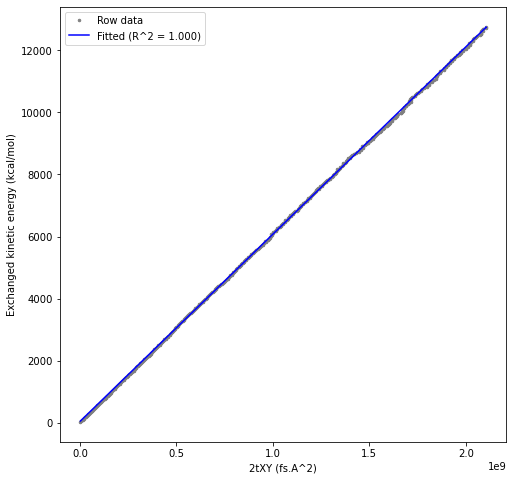

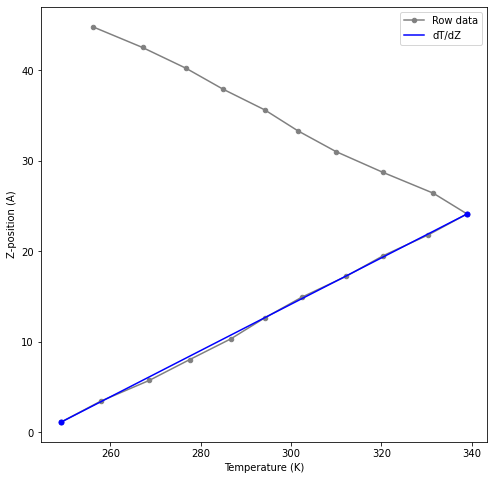

In [8]:
def analyzeThermalConductivity(prefix_thermo,
                               energy,
                               mesh,
                               lin_approx,
                               profile
                               ):
    lz, dens, flux = AnalyzeExchangedEnergy (prefix_thermo, energy)
    dtdz = AnalyzeTemperatureDistribution (mesh, lz, lin_approx, prefix_thermo, profile)
    kappa = -1.0 * (-1.0 * flux) / dtdz
    print ("Length of z-axis:     {:.5f} A".format (lz))
    print ("Thermal_conductivity: {:.5f} W/(m.K)".format (kappa))
    print ("Density:              {:.5f} g/cm^3".format (dens))
    with open (prefix_thermo + "thermo.dat", "w") as fp:
        fp.write ("Length of z-axis:     {:.5f} A\n".format (lz))
        fp.write ("Thermal_conductivity: {:.5f} W/(m.K)\n".format (kappa))
        fp.write ("Density:              {:.5f} g/cm^3\n".format (dens))